In [1]:
from tensorflow import keras
from src.ParticleNet.PointNet import PointNetLayer
from src.ParticleNet.GlobalPooling import GlobalAveragePoolingLayer
from utilities import utilities
from ML.ParticleCloud.data_loaders import load_data_top_tagging

#### Loading the Data

In [2]:
X_train, y_train = load_data_top_tagging(top_quark_path="../../../Data/Trainning/t_jets.csv", quark_data_path="../../../Data/Trainning/q_jets.csv", gluon_data_path="../../../Data/Trainning/g_jets.csv")
X_val, y_val = load_data_top_tagging(top_quark_path="../../../Data/Validation/t_jets.csv", quark_data_path="../../../Data/Validation/q_jets.csv", gluon_data_path="../../../Data/Validation/g_jets.csv")

In [3]:
print(f"Size of the Training set: {len(X_train)}")
print(f"Size of the Validation set: {len(X_val)}")

Size of the Training set: 254254
Size of the Validation set: 44869


#### Setting up the NN

In [15]:
# MLP for the first conv layer
mlp_jets = keras.Sequential([
    keras.layers.InputLayer(shape=[4]),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(negative_slope=0.2)
])

mlp_jets2 = keras.Sequential([
    keras.layers.InputLayer(shape=[32]),
    keras.layers.Dense(64),
    keras.layers.LeakyReLU(negative_slope=0.2),
    keras.layers.Dense(64),
    keras.layers.LeakyReLU(negative_slope=0.2)
])

# MLP for the second convolutional layer
jet_tag_model = keras.Sequential([
    keras.layers.InputLayer(shape=(30, 5)),
    PointNetLayer(mlp=mlp_jets, output_dim=32),
    PointNetLayer(mlp=mlp_jets2, output_dim=64),
    GlobalAveragePoolingLayer(),
    keras.layers.Dense(128, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(2, activation='softmax')
])

jet_tag_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ point_net_layer_2               │ (None, 30, 33)         │         1,216 │
│ (PointNetLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ point_net_layer_3               │ (None, 30, 65)         │         6,272 │
│ (PointNetLayer)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer_1  │ (None, 64)             │             0 │
│ (GlobalAveragePoolingLayer)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,066 (62.76 KB)

 Trainable params: 16,066 (62.76 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
jet_tag_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = jet_tag_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))   

Epoch 1/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8319 - loss: 0.3828 - val_accuracy: 0.8568 - val_loss: 0.3463
Epoch 2/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8625 - loss: 0.3385 - val_accuracy: 0.8723 - val_loss: 0.3153
Epoch 3/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8714 - loss: 0.3233 - val_accuracy: 0.8745 - val_loss: 0.3102
Epoch 4/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8735 - loss: 0.3154 - val_accuracy: 0.8697 - val_loss: 0.3238
Epoch 5/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8731 - loss: 0.3147 - val_accuracy: 0.8705 - val_loss: 0.3235
Epoch 6/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8748 - loss: 0.3121 - val_accuracy: 0.8787 - val_loss: 0.2997
Epoch 7/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8766 - loss: 0.3066 - val_accuracy: 0.8760 - val_loss: 0.3084
Epoch 8/100
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8759 -

In [18]:
# perfoming the prediction
y_train_pred = jet_tag_model.predict(X_train)
y_val_pred = jet_tag_model.predict(X_val)

7946/7946 ━━━━━━━━━━━━━━━━━━━━ 6s 686us/step
1403/1403 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step


In [8]:
print("Trainnig set:")
utilities.display_metrics(y_true=y_train[:, 0], y_pred=y_train_pred[:, 0] > 0.5)
print("Validation set:")
utilities.display_metrics(y_true=y_val[:, 0], y_pred=y_val_pred[:, 0] > 0.5)

Trainnig set:
Recall: 0.9222
Precision: 0.8602
Confusion Matrix:
[[106418  19271]
 [ 10006 118559]]
Validation set:
Recall: 0.9195
Precision: 0.8604
Confusion Matrix:
[[18796  3385]
 [ 1826 20862]]


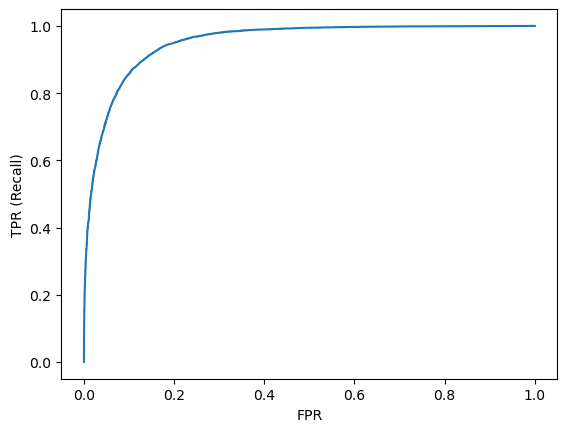

AUC: 0.9522


In [9]:
utilities.display_roc_curve(y_true=y_val[:, 0], y_score=y_val_pred[:, 0])

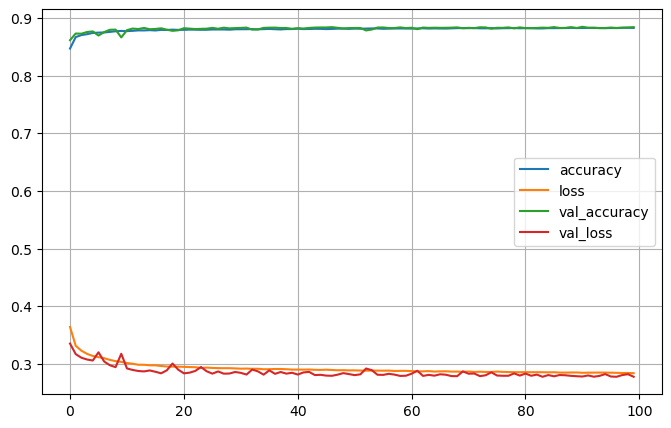

In [10]:
utilities.plot_hist_trainning(history)

In [11]:
utilities.save_model(jet_tag_model, history, "Top_Tagging_PointNet")